Picture this: you're sitting at your computer, and with a few keystrokes, you're eavesdropping on a pilot chatting with air traffic control. No, you haven't broken any laws (I hope). You've just used a software-defined radio (SDR) to capture a real-world AM transmission, and now you're ready to demodulate it and hear what's being said.

In this article, I'll show the process of AM demodulation with software-defined radio, from the raw radio signal to audible speech, with animations and code for each step along the way. You can also download this as a Jupyter notebook to follow along and experiment with the demodulation process yourself from the [GitHub Repo](https://github.com/ccostes/ml/tree/main/am_explainer).

The process itself is actually quite simple, but involves some really cool signal processing concepts that will give you a taste of the fascinating world of SDR.

## AM Radio

Amplitude Modulation (AM) is the simplest way to transmit audio signals via radio. You might wonder why we don't just transmit the audio signals directly, but this is undesirable for a variety of reasons (your antenna would need to hundreds of kilometers long, for one). Higher frequencies are generally easier to transmit, so the next simplest thing is to combine the audio signal with a higher frequency sine wave "carrier", transmit that signal, and then remove the carrier on the receiving end.
```
carrier = 1 + sin(2 * pi * frequency)
modulated = ((1 + audio) * carrier)
```
The animation below shows what this looks like as the carrier frequency increases from zero, but actual signals will use a much higher carrier frequency (aircraft radio is around 120 MHz).
<video controls="" autoplay="" loop="">
    <source src="static/am.mp4" type="video/mp4">
</video>

## Software-Defined Radio
An important detail is how we will receive the signals we wish to process. Traditionally, radios could only be implemented with analog electronics, but with modern processing power we can replace a lot of that signal-specific circuitry with software; this is called *Software-Defined Radio (SDR)*. This allows us to receive a wide variety of signals, from  satellite weather imagery to TV broadcasts, with the a single hardware device. Processing the signal in software is a lot more flexible, and enables entirely new capabilities (like using a machine learning model).
![USB SDR Receiver](static/rtlsdr.png)
SDR receivers capture a "window" of frequencies, and we can tune this window so that it includes the frequency we are interested in. This also means that we can receive multiple signals simultaneously if they fall within that window, e.g. simultaneously listening to multiple radio stations; neat!

## AM Demodulation
Now that you understand what an AM signal is and how we are receiving it, lets look at each step of the process to turn a raw SDR signal containing an AM signal into audio.

### Input signal
We will start by taking a look at our input signal using what's called a spectrogram. This shows the magnitude of a signal at various frequencies on the vertical axis, over time on the horizontal axis. Note that these frequencies are relative to where the receiver was tuned, e.g. tuned to 500 kHz, a 300 kHz signal would show up on the plot at -200 kHz.
The code below reads recorded SDR data, stored as pairs of bytes representing a complex signal, and plots the spectrogram. Complex values aren't as scary as they sound, and in this context all it means is that our input is a two-dimensional signal which includes magnitude (referred to as `I`, or *real*) and phase (or `Q`, a.k.a. *imaginary*) information.

In [1]:
sr_in = 1.04e6  # SDR sampling rate
carrier_in = int(sr_in / 4) * -1  # SDR tuned to freq + (sampling rate / 4)
sr_aud = 8192  # Desired audio sampling rate
downsample = round(sr_in / sr_aud)  # Downsampling factor
print(f"Input Rate: {sr_in/1e3} kHz\nAudio Rate: {sr_aud/1e3} kHz\nDownsampling factor: {downsample}")
# Read the raw IQ bytes
import numpy as np
filename = "twr_rx.bin"
with open(filename, "rb") as f:
    raw_bytes = np.fromfile(f, dtype=np.uint8)
# Convert raw bytes to IQ components (-1.0 to 1.0 range)
iq_samples = (raw_bytes - 127.5) / 127.5
i_samples = iq_samples[0::2]
q_samples = iq_samples[1::2]
complex_samples = i_samples + 1j * q_samples

from util import save_audio, plot_waveform, plot_waterfall_spectrum, animate_waveform, set_outdir
set_outdir('gen')
plot_waterfall_spectrum(complex_samples.real, sr_in, title="SDR Signal", filename='sdr_data.png')

Input Rate: 1040.0 kHz
Audio Rate: 8.192 kHz
Downsampling factor: 127


/Users/ccostes/dev/blog-hugo/content/posts/ml/am_explainer/util.py:129: RuntimeWarning: divide by zero encountered in log10
  waterfall[:, i] = 20 * np.log10(np.abs(fft_shifted))


![SDR Signal](gen/sdr_data.png)
You can see in the spectrogram that we captured a few different signals, shown by the bright horizontal lines. The signal we want to demodulate is at 120.9 MHz, which shows here as the continuous line just below 200 kHz since the receiver was tuned to 121.16 MHz.

### Shift to Baseband
Recall that an AM signal mixes the audio with a high-frequency carrier, in this case at a frequency of 120.9 MHz, which effectively shifts the frequency of the audio up by that amount. Naturally, the first step to recover the audio is to reverse that and shift it back down, specifically by the frequency of the carrier

This is implemented by the code below. For our purposes it isn't necessary to understand how or why it works, as long as you understand that the result (shown in the spectrogram below) has moved our signal of interest to 0 Hz, or *Baseband* (or at least pretty close).

In [2]:
pattern = np.array([1, 1j, -1, -1j], dtype=np.complex64)
pattern_repeated = np.tile(pattern, len(complex_samples) // len(pattern))
shifted_complex = complex_samples * pattern_repeated
plot_waterfall_spectrum(shifted_complex, sr_in, title="Baseband Signal", filename='baseband.png')

![Baseband Signal](gen/baseband.png)
### Downsample
Looking at the spectrogram after shifting the input so that our AM signal is at baseband, the audio portion we are interested in (~300 Hz to 3 kHz) represents a tiny portion of the over one-million-Hz frequency range in the data. We can get rid of all that extra information with what's called *downsampling*. 
Fundamentally, lower-frequency signals can be represented by fewer data points per second, called the *sampling rate*. This concept is illustrated in the animation below, showing two signals sampled at increasing rates, with a reconstructed signal based on the sampled points. You can see that the low frequency signal is approximated with much lower sampling rate than the high frequency signal.

<video controls="" autoplay="" loop="">
    <source src="static/sampling.mp4" type="video/mp4">
</video>

The corollary to this is that the *maximum* frequency a given sample rate can represent is twice the sampling rate (see [Nyquist-Shannon Theorem](https://en.m.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) for details). Any signals outside that range will be "folded back" into the range, called *aliasing*. You can see this effect on the high-frequency signal in the animation as lower-frequency sine waves that appear at various sampling rates.

Applying this to our data, we can get rid of the signals we're not interested in, *and* have a lot less data to process, by lowering the sampling rate to roughly double the highest frequency we're interested in. Concretely, an ~8 kHz sampling rate is sufficient for voice audio which requires only 16 kB/s of data, compared to our input signal at over 2MB per second!
To avoid the higher-frequency signals in our data from aliasing and interfering with the audio we first apply a filter to remove any signals at frequencies above the max of our new sampling rate.

In [3]:
import torch
import modulation
baseband = torch.tensor(shifted_complex, dtype=torch.complex64)  # Convert to complex torch tensor
# Apply anti-aliasing low-pass filter
anti_aliasing_cutoff = sr_aud / 2
anti_aliasing_kernel = modulation.design_low_pass_filter(
    anti_aliasing_cutoff, sample_rate=sr_in, kernel_size = 101
)
filtered = modulation.fir_low_pass_filter(
    baseband.unsqueeze(0).unsqueeze(0),
    anti_aliasing_kernel.unsqueeze(0).unsqueeze(0),
    padding="same",
)
plot_waterfall_spectrum(filtered, sr_in, title="Anti-alias Filtered", filename='baseband_filtered.png')

![Anti-Alias-Filtered Baseband](gen/baseband_filtered.png)
You can see that the filtering has removed all of the other signals from our data, leaving a thin bright line in the middle that contains our audio.
This filtered signal can now be downsampled by simply picking out samples at the new rate and throwing the rest away. E.g. if the original sampling rate were 1 kHz and our desired rate was 100 Hz we would save every 10th sample.

In [4]:
# Decimate to desired sample rate
decimation_factor = int(sr_in // sr_aud)
decimated = filtered[::decimation_factor]
save_audio('decimated.wav', decimated.real, sr_aud)
plot_waterfall_spectrum(decimated, sr_aud, include_negative_frequencies=False, title="Decimated", filename='decimated.png')

![Decimated Signal](gen/decimated.png)
The spectrogram of the decimated signal shows the new frequency range of up to about 4 kHz, and you can also see the audio data. With just these two steps we are actually quite close to the desired audio, as you can start to hear below, but there's clearly something wrong.
<audio controls src="gen/decimated.wav"></audio>
You might be able to guess what the problem is from the spectrogram of the decimated signal, but recall that AM signal is comprised on a carrier wave modulated by the audio signal. That carrier wave is still present, visible as the bright continuous line around 200 Hz on the spectrogram, which is why the audio sounds distorted.

### Demodulation
In order to recover the original audio signal we need to remove the carrier wave. The details of how this works are outside the scope of this article (recall the original premise was that you *didn't* need to know how to do it), but the gist is that because our signal is complex, with magnitude and phase dimensions, we can extract the audio modulation signal by simply taking the magnitude of the signal.

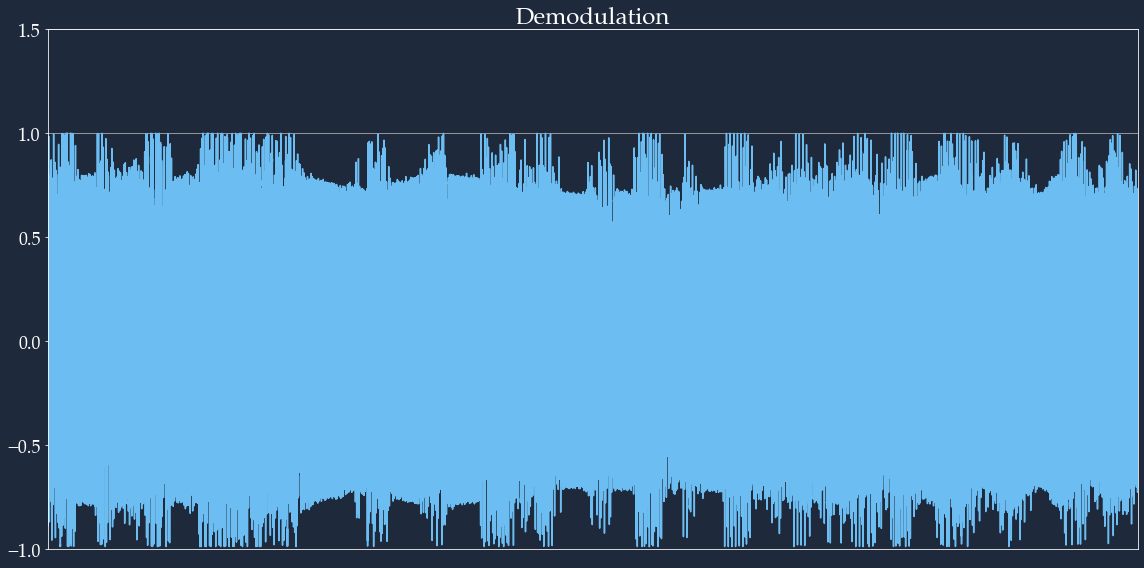

In [5]:
demodulated = torch.abs(decimated)
animate_waveform(decimated.real, demodulated.real, sr_aud, "Demodulation", ylim=[-1,1.5], filename="demodulation.mp4")

The effect of this is apparent if we look at the signal waveform before and after the `torch.abs` operation, where the "thickness" of the decimated signal is caused by the presence of the carrier.
<video controls="" autoplay="" loop="">
    <source src="static/demodulation.mp4" type="video/mp4">
</video>

Finally, there could be some non-audio signals left-over, so we apply a final bandpass filter to remove anything outside the audio frequency range of 300 Hz to 3 kHz.

In [6]:
low_cut_freq = 300
high_cut_freq = 3000
fir_kernel = modulation.design_band_pass_filter(
    low_cut_freq, high_cut_freq, sr_aud, kernel_size=101
)
filtered = modulation.fir_low_pass_filter(
    demodulated.unsqueeze(0).unsqueeze(0),
    fir_kernel.unsqueeze(0).unsqueeze(0),
    padding="same",
)
save_audio('demodulated.wav', filtered, sr_aud)
plot_waveform(filtered, sr_aud, title="Demodulated Audio", filename='demodulated_waveform.png')
plot_waterfall_spectrum(filtered, sr_aud, include_negative_frequencies=False, title="Demodulated Audio", filename='demodulated_waterfall.png')

![Demodulated Signal Spectrum](gen/demodulated_waterfall.png)
The carrier signal is gone, and playing the signal as audio, you can hear that we have successfully demodulated the AM signal!

<audio controls src="gen/demodulated.wav"></audio>
![Demodulated Signal Waveform](gen/demodulated_waveform.png)
You've now seen all of the steps required to demodulate an AM radio signal, and hopefully have an intuition for what is happening in each.

The next installment will introduce machine learning, designing a model architecture for this problem, and devising a plan for creating synthetic training data. Stay tuned!